![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [154]:
import warnings
warnings.filterwarnings('ignore')

In [155]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn import metrics


In [156]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable
bikes['hour'] = bikes.index.hour

# Visualización de los datos
print(bikes.head())

                     season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  total  hour  
datetime                                                                   
2011-01-01 00:00:00        81        0.0       3          13     16     0  
2011-01-01 01:00:00        80        0.0       8          32     40     1  
2011-01-01 02:00:00        80        0.0       5          27     32     2  
2011-01-01 03:00:00        75        0.0       3          10     13     3  
2011-01-01 04:00:0

In [37]:
print(bikes.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  total       10886 non-null  int64  
 11  hour        10886 non-null  int32  
dtypes: float64(3), int32(1), int64(8)
memory usage: 1.0 MB
None


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [157]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Basándonos en los datos proporcionados, se observa una clara variación en la demanda de alquiler de bicicletas según la estación del año. El análisis revela que el verano muestra la mayor demanda promedio, con alrededor de 234 alquileres, seguido de cerca por el primavera, con aproximadamente 215 alquileres en promedio. Estas estaciones, caracterizadas por temperaturas moderadas y condiciones climáticas más estables, parecen favorecer la actividad de ciclismo al aire libre. Por otro lado, la invierno exhibe la menor demanda, con alrededor de 116 alquileres en promedio, quizás debido al clima frío y lluvias.

Este patrón de demanda estacional puede ser crucial para la planificación y gestión de servicios de alquiler de bicicletas. Por ejemplo, las empresas podrían ajustar sus operaciones y ofertas promocionales para aprovechar al máximo los períodos de alta demanda en primavera y verano, mientras que podrían considerar estrategias alternativas, como campañas de marketing específicas o descuentos, para estimular la demanda durante los períodos más tranquilos de otoño e invierno. Además, comprender estos patrones estacionales también puede ayudar en la gestión de inventario y en la asignación de recursos, asegurando que haya suficientes bicicletas disponibles durante los picos de demanda y optimizando la eficiencia operativa durante los períodos más tranquilos.

In [158]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Basándonos en los datos proporcionados, se observa una clara variación en la demanda de alquiler de bicicletas según la hora del día. El análisis revela que las horas con mayor demanda promedio son las comprendidas entre las 17:00 y las 18:00 horas, con aproximadamente 469 y 431 alquileres en promedio respectivamente. Estas horas coinciden típicamente con el final de la jornada laboral, donde las personas podrían optar por utilizar bicicletas como medio de transporte para regresar a casa. Además, las horas comprendidas entre las 7:00 y las 9:00 horas también muestran una demanda significativa, con alrededor de 213 a 363 alquileres en promedio, correspondiendo al inicio de la jornada laboral y el desplazamiento hacia el trabajo.

Este patrón de demanda horaria puede ser útil para la planificación y gestión de servicios de alquiler de bicicletas. Por ejemplo, las empresas podrían ajustar sus operaciones, como el número de bicicletas disponibles y las tarifas, para satisfacer la demanda durante los picos de uso observados en las horas punta de la mañana y la tarde. Además, podrían implementar estrategias de marketing o promociones especiales para fomentar el uso de bicicletas durante las horas de menor demanda, como durante la noche o las primeras horas de la mañana.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

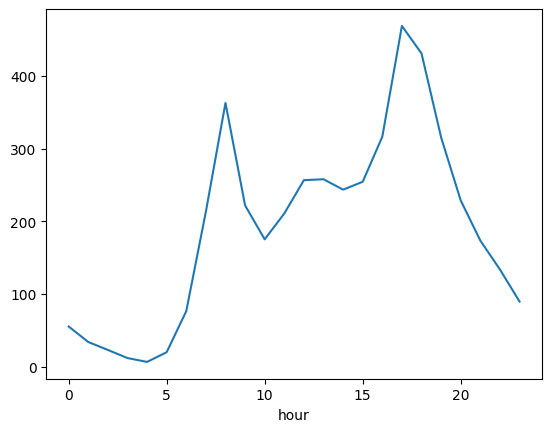

In [159]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

De acuerdo a la grafica vemos que hay mayor cantidad de alquiler de bicicletas en horas de la mañana se podria decir que horas de entrada de oficina y en horarios de la tarde de finalizacion de jornada laboral. Esto refleja que las personas utilizan la bicicleta como medio de transporte para movilizarse hacia el trabajo y despues del trabajo.

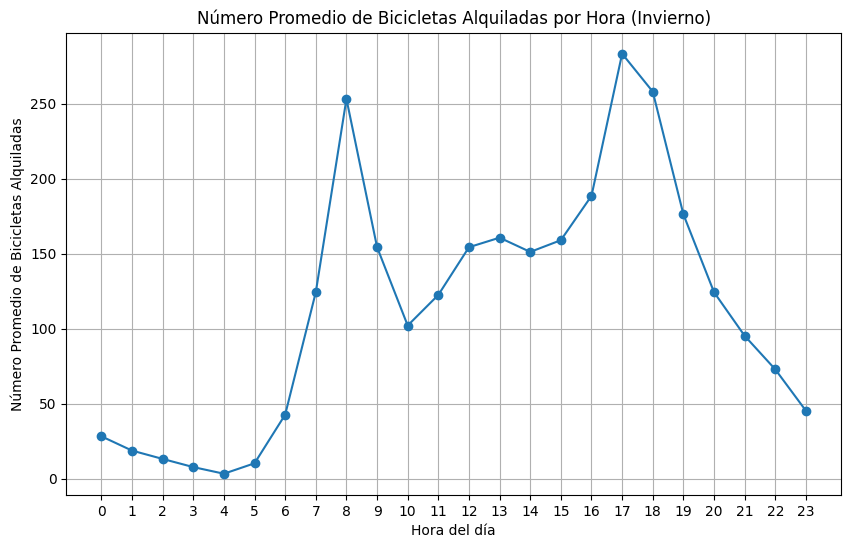

In [160]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos

# Filtrar el DataFrame por la temporada de invierno (season=1)
bikes_invierno = bikes[bikes['season'] == 1]

# Agrupar por hora y calcular la media del total de alquileres
promedio_por_hora = bikes_invierno.groupby('hour')['total'].mean()

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(promedio_por_hora, marker='o', linestyle='-')
plt.title('Número Promedio de Bicicletas Alquiladas por Hora (Invierno)')
plt.xlabel('Hora del día')
plt.ylabel('Número Promedio de Bicicletas Alquiladas')
plt.xticks(promedio_por_hora.index)
plt.grid(True)
plt.show()


Se siguen manteniendo los picos de alquiler de bicicletas en horas de la mañana y en horas de la tarde pero se ve una reduccion considerable en el promedio de alquiler de bicicletas durante la temporada de invierno.

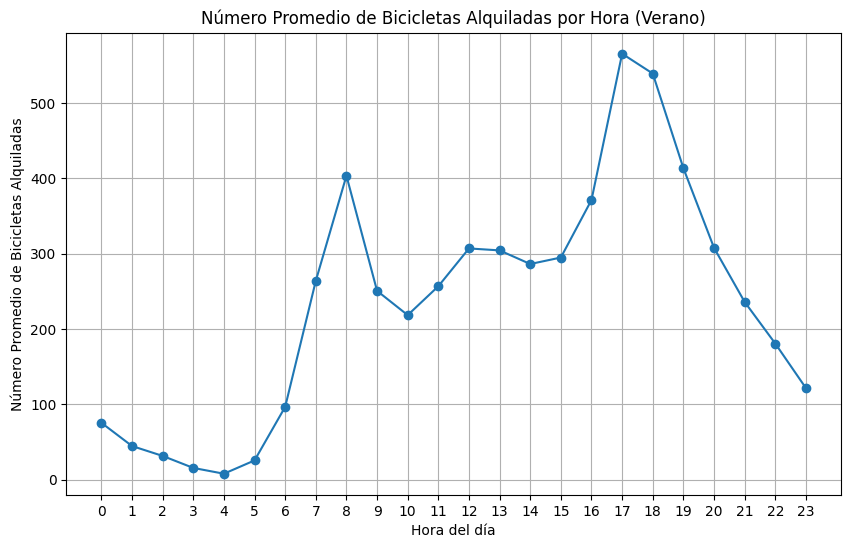

In [161]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos

bikes_verano = bikes[bikes['season'] == 3]

# Agrupar por hora y calcular la media del total de alquileres
promedio_por_hora = bikes_verano.groupby('hour')['total'].mean()

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(promedio_por_hora, marker='o', linestyle='-')
plt.title('Número Promedio de Bicicletas Alquiladas por Hora (Verano)')
plt.xlabel('Hora del día')
plt.ylabel('Número Promedio de Bicicletas Alquiladas')
plt.xticks(promedio_por_hora.index)
plt.grid(True)
plt.show()

Se siguen manteniendo los picos de alquiler de bicicletas en horas de la mañana y en horas de la tarde pero se ve un incremento considerable en el promedio de alquiler de bicicletas durante la temporada de verano.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [162]:

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X = bikes[['season', 'hour']]
y = bikes['total']
XTrain, XTest, YTrain, YTest = train_test_split(X, y, test_size=0.2, random_state=0)

# Convertir la variable categórica "season" en variables dummy
XTrain = pd.get_dummies(XTrain, columns=['season'], drop_first=True)
XTest = pd.get_dummies(XTest, columns=['season'], drop_first=True)

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(XTrain, YTrain)

LinearRegression()

In [163]:
# Imprimir los coeficientes
print("Coeficientes del modelo:")
for feature, coef in zip(XTrain.columns, model.coef_):
    print(f"{feature}: {coef}")

# Predicciones en el conjunto de prueba
y_pred = model.predict(XTest)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(YTest, y_pred)
print("MSE: " + str(mse))

Coeficientes del modelo:
hour: 10.53927097567384
season_2: 99.24935554363347
season_3: 118.6136446555492
season_4: 86.3478783438267
MSE: 25931.648964912973


Al observar los coeficientes del modelo de regresión lineal, puedo inferir que la hora del día y la temporada tienen un impacto significativo en el número total de alquileres de bicicletas en el sistema Capital Bikeshare.

Por ejemplo, el coeficiente para la hora es positivo (10.53), lo que sugiere que, en promedio, cada hora adicional resulta en un aumento de aproximadamente 10 alquileres de bicicletas. Este hallazgo tiene sentido, ya que es probable que más personas alquilen bicicletas durante las horas pico de la mañana y la tarde.

Además, los coeficientes para las diferentes estaciones también son notables. Por ejemplo, el coeficiente para la temporada de verano (99.24) indica que, en promedio, hay alrededor de 99 alquileres de bicicletas más durante el verano en comparación con la primavera. Este patrón puede explicarse por la preferencia de las personas por actividades al aire libre durante los meses más cálidos.

Se podria afirmar que la hora del día y la temporada son factores cruciales para predecir la demanda de alquiler de bicicletas.

La regresión lineal,presenta limitaciones al predecir la demanda de alquiler de bicicletas. Las suposiciones de linealidad pueden ser insuficientes para capturar relaciones complejas entre la hora del día, la temporada y la demanda de bicicletas.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [164]:
# Celda 4

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X = bikes[['season', 'hour']]
y = bikes['total']
XTrain, XTest, YTrain, YTest = train_test_split(X, y, test_size=0.2, random_state=0)

# Crear listas para almacenar los modelos y mse
modelos = []
mse_scores = []

# Iterar sobre las variables "hour" y "season"
for hour in range(24):
    for season in range(1, 5):
        # Filtrar el conjunto de datos para la hora y la temporada actual
        XTrain_filtered = XTrain[(XTrain['hour'] == hour) & (XTrain['season'] == season)]
        YTrain_filtered = YTrain[XTrain_filtered.index]

        # Crear y entrenar el modelo de árbol de decisiones con 6 nodos
        model = DecisionTreeRegressor(max_leaf_nodes=6)
        model.fit(XTrain_filtered, YTrain_filtered)

        # Calcular el error cuadrático medio en el conjunto de entrenamiento
        YTrain_pred = model.predict(XTrain_filtered)
        mse_train = mean_squared_error(YTrain_filtered, YTrain_pred)

        modelos.append(model)
        mse_scores.append(mse_train)

# Encontrar el índice del modelo de mejor modelo (error mas bajo)
best_model_idx = np.argmin(mse_scores)

# Obtener el mejor modelo y su error
best_model = modelos[best_model_idx]
best_mse = mse_scores[best_model_idx]

print("MSE del mejor modelo: " + str(best_mse))


MSE del mejor modelo: 9.443877551020407


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [165]:
# Celda 5

X = bikes[['season', 'hour']]
y = bikes['total']

# Dividir los datos en conjuntos de entrenamiento y validación
XTrain, XTest, YTrain, YTest = train_test_split(X, y, test_size=0.2, random_state=0)

# Definir el espacio de búsqueda de parámetros
param_grid = {
    'max_depth': range(1, 21),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 21),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Inicializar el modelo de árbol de decisiones
tree = DecisionTreeRegressor(random_state=0)

# Configurar la búsqueda de cuadrícula utilizando validación cruzada de 5 veces
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Realizar la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(XTrain, YTrain)

# Obtener el mejor modelo encontrado por la búsqueda de cuadrícula
best_tree = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de validación
y_prob_pred = best_tree.predict(XTest)
mse = mean_squared_error(YTest, y_prob_pred)

print("Mejores parámetros encontrados:", grid_search.best_params_)
print("MSE: ", mse)


Mejores parámetros encontrados: {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
MSE:  13346.771363618856


Después de realizar un análisis exhaustivo de hiperparámetros utilizando un árbol de decisiones, se encontró que el mejor modelo, tiene una configuración de hiperparámetros que incluye una profundidad máxima de 8 niveles, con una selección automática de características (`max_features='auto'`), y criterios de división mínima de una sola muestra en las hojas (`min_samples_leaf=1`) y dos muestras para realizar una división en los nodos internos (`min_samples_split=2`). Este modelo alcanzó un error cuadrático medio (MSE) de aproximadamente 13,346 en el conjunto de validación.

Al comparar este desempeño con el modelo de regresión lineal, que obtuvo un MSE de aproximadamente 25,932, se observa una mejora significativa en la capacidad predictiva del árbol de decisiones. Esto sugiere que el modelo de árbol de decisiones, con una configuración óptima de hiperparámetros, es más capaz de capturar las relaciones complejas entre las variables predictoras y la variable objetivo, lo que resulta en predicciones más precisas en comparación con el modelo de regresión lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [166]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [167]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 0 to 5999
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            6000 non-null   object 
 1   timedelta                      6000 non-null   float64
 2   n_tokens_title                 6000 non-null   float64
 3   n_tokens_content               6000 non-null   float64
 4   n_unique_tokens                6000 non-null   float64
 5   n_non_stop_words               6000 non-null   float64
 6   n_non_stop_unique_tokens       6000 non-null   float64
 7   num_hrefs                      6000 non-null   float64
 8   num_self_hrefs                 6000 non-null   float64
 9   num_imgs                       6000 non-null   float64
 10  num_videos                     6000 non-null   float64
 11  average_token_length           6000 non-null   float64
 12  num_keywords                   6000 non-null   float6

In [168]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [169]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [170]:
# Celda 6

# 1. Construir y entrenar un árbol de decisión, parametro elegido es profundidad
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_clf.fit(X_train, y_train)

# 2. Construir y entrenar una regresión logística
logistic_reg = LogisticRegression(random_state=0)
logistic_reg.fit(X_train, y_train)

# 3. Evaluar el desempeño de los modelos
# Predicciones del árbol de decisión
tree_pred = tree_clf.predict(X_test)
# Predicciones de la regresión logística
logistic_pred = logistic_reg.predict(X_test)

# Calcular métricas de evaluación
tree_accuracy = accuracy_score(y_test, tree_pred)
tree_f1 = f1_score(y_test, tree_pred)

logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_f1 = f1_score(y_test, logistic_pred)

# Mostrar los resultados
print("Desempeño del Árbol de Decisión:")
print("Accuracy:", tree_accuracy)
print("F1-Score:", tree_f1)
print("\nDesempeño de la Regresión Logística:")
print("Accuracy:", logistic_accuracy)
print("F1-Score:", logistic_f1)

Desempeño del Árbol de Decisión:
Accuracy: 0.6005050505050505
F1-Score: 0.6235126130414088

Desempeño de la Regresión Logística:
Accuracy: 0.6136363636363636
F1-Score: 0.5871559633027522


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados.

Nota:

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [171]:
# 1. árboles de decisión donde max_depth

# Creación de 100 muestras
n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples_tree_1 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 100 modelos con las 100 muestras
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=5, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples_tree_1[i]], y_train.iloc[samples_tree_1[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

# y_pred_df.head()


In [172]:
# 2. árboles de decisión donde min_samples_leaf

# Creación de 100 muestras
n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples_tree_2 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 100 modelos con las 100 muestras
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)

trees_2 = {}
for i in range(n_estimators):
    trees_2[i] = DecisionTreeClassifier(max_features="sqrt", min_samples_leaf=10, random_state=seeds[i])
    trees_2[i].fit(X_train.iloc[samples_tree_2[i]], y_train.iloc[samples_tree_2[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df_2 = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df_2.iloc[:, i] = trees_2[i].predict(X_test)

# y_pred_df.head()


In [173]:
# 3. Logistic Regression

# Creación de 100 muestras
n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples_log = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 100 modelos con las 100 muestras
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)

logistic_regressions = {}
for i in range(n_estimators):
    logistic_regressions[i] = LogisticRegression(random_state=seeds[i])
    logistic_regressions[i].fit(X_train.iloc[samples_log[i]], y_train.iloc[samples_log[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df_3 = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df_3.iloc[:, i] = logistic_regressions[i].predict(X_test)


In [174]:
# Concatenar las matrices de predicciones
y_pred_total = np.concatenate((y_pred_df, y_pred_df_2, y_pred_df_3), axis=1)

# Aplicar la votación mayoritaria en la matriz y_pred_total
y_pred = (y_pred_total.sum(axis=1) >= ((n_estimators*3) / 2)).astype(np.int64)

# Desempeño al hacer votación mayoritaria
print("F1 Score:", metrics.f1_score(y_pred, y_test))
print("Accuracy Score:", metrics.accuracy_score(y_pred, y_test))

F1 Score: 0.6294573643410852
Accuracy Score: 0.6378787878787879


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [175]:
# Celda 8
# 1. árboles de decisión donde max_depth
samples_oob_tree_1 = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples_tree_1:
    samples_oob_tree_1.append(sorted(set(range(n_samples)) - set(sample)))

# Estimación de los errores OOB para cada clasificador
errors_tree_1 = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_tree_1 = trees[i].predict(X_train.iloc[samples_oob_tree_1[i]])
    errors_tree_1[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob_tree_1[i]], y_pred_tree_1)

In [176]:
# 2. árboles de decisión donde min_samples_leaf
samples_oob_tree_2 = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples_tree_2:
    samples_oob_tree_2.append(sorted(set(range(n_samples)) - set(sample)))

# Estimación de los errores OOB para cada clasificador
errors_tree_2 = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_tree_2 = trees_2[i].predict(X_train.iloc[samples_oob_tree_2[i]])
    errors_tree_2[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob_tree_2[i]], y_pred_tree_2)

In [177]:
# 3. Logistic Regression
samples_oob_log = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples_log:
    samples_oob_log.append(sorted(set(range(n_samples)) - set(sample)))

# Estimación de los errores OOB para cada clasificador
errors_log = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_log = logistic_regressions[i].predict(X_train.iloc[samples_oob_log[i]])
    errors_log[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob_log[i]], y_pred_log)

In [178]:
# Todos lo errores
errors_total = np.concatenate((errors_tree_1, errors_tree_2, errors_log), axis=0)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors_total) / (1 - errors_total).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_total) * alpha).sum(axis=1)

# Desempeño al hacer votación ponderada
y_pred_pond = (weighted_sum_1 >= 0.5).astype(np.int64)

# Desempeño al hacer votación mayoritaria
print("F1 Score:", metrics.f1_score(y_pred_pond, y_test))
print("Accuracy Score:", metrics.accuracy_score(y_pred_pond, y_test))

F1 Score: 0.628099173553719
Accuracy Score: 0.6363636363636364


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

La comparación entre la votación ponderada y la votación mayoritaria puede proporcionar una perspectiva interesante sobre cómo diferentes enfoques pueden afectar el rendimiento de un modelo de ensamblaje. En cuanto a las métricas de evaluación obtenidas, ambas técnicas muestran resultados similares en términos de F1 Score y Accuracy Score. Esto sugiere que, en este caso particular, no hay una diferencia significativa en el rendimiento entre ambas estrategias de votación.

Una ventaja de la votación ponderada es que permite asignar diferentes pesos a los modelos individuales, lo que puede ser útil cuando algunos modelos tienen un rendimiento mejor o peor en ciertas características. Sin embargo, determinar los pesos óptimos puede ser un desafío y requerir un ajuste de cuidado. Por otro lado, la votación mayoritaria es más simple de implementar y entender, ya que simplemente cuenta el número de votos para cada clase y elige la clase con más votos.

Los resultados obtenidos sugieren que los modelos individuales utilizados en el ensamblaje tienen un rendimiento equilibrado, lo que resulta en resultados similares para ambas técnicas de votación.